In [103]:
import pandas as pd
import random
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix

import statsmodels.api as sm


from scipy import stats


In [440]:
############### Making a balanced dataframe #################
random.seed(1)

df_emotion = pd.read_csv("LIWC_and_emotions.csv")
#pos = (df_emotion_and_LIWC[df_emotion_and_LIWC["flagged"]=="Y"])
#neg= (df_emotion_and_LIWC[df_emotion_and_LIWC["flagged"]=="N"])
#df_neg_only = neg.sample(n=len(pos))

#df_emotion = pd.concat([df_neg_only, pos])

############### A smaller subset of 1000 entries #################
#df_neg_subset = neg.sample(n=500)
#df_pos_subset = pos.sample(n=500)
#df_emotion_subset = pd.concat([df_neg_subset, df_pos_subset])


############## the time-adjusted rating feaaute that was previously extracted from the database ###################
df_time_rating = pd.read_csv("rating_by_date_full.csv")
df_time_rating=df_time_rating.rename(columns={"0": "reviewID","1": "RatingPrior"})
merged=pd.merge(df_emotion,df_time_rating, on='reviewID',how="left").replace({np.nan: None})
merged[merged["RatingPrior"].isna()]

for i, row in merged.iterrows():
    #print(merged.at[i,"RatingPrior"])
    if merged.at[i,"RatingPrior"]==None or len(merged.at[i,"RatingPrior"])==0:
        merged.at[i,"RatingPriorToReview"]=None
    else:
        merged.at[i,"RatingPriorToReview"]=merged.at[i,"RatingPrior"].strip('][(),')

In [441]:
import sqlite3

def connect_db(db_file):
    conn = None
    try:
        conn = sqlite3.connect(db_file)
    except Error as e:
        print(e)

    return conn

conn = connect_db("/Users/jamesfyfe/summer vac misc/yelpResData.db")
res_ids = tuple(merged["restaurantID"])
cur = conn.cursor()

query_dist = "SELECT count(*),count(distinct restaurantID) FROM restaurant"

cur.execute(query_dist)
rows_dist = cur.fetchall()
print(rows_dist) # checking for duplicates to see if maybe same record with diff ratings exists for a restaurant

# get restaurants matching our balanced reviews dataset

                



[(242652, 242652)]


In [442]:
query = "SELECT * FROM restaurant WHERE restaurantID in {}".format(res_ids)

cur.execute(query)
rows_restaurant = pd.DataFrame(cur.fetchall())
#merged["ResRating"] = rows_restaurant[[rows_restaurant[0]==merged["restaurantID"]]][4]
                
cur.execute("""SELECT restaurantid,count(*) as c
                                  FROM REVIEW 
                                  group by restaurantid""")
count_reviews = pd.DataFrame(cur.fetchall())
                
rows_restaurant = rows_restaurant[[0,4]]
rows_restaurant= rows_restaurant.rename(columns={0:"restaurantID",4:"ResRating"})
count_reviews = count_reviews.rename(columns={0:"restaurantID",1:"NumReviews"})

In [443]:
len(count_reviews)

250078

In [444]:
m_t = pd.merge(rows_restaurant,count_reviews)
merged=pd.merge(merged, m_t)

In [445]:
missed_none = merged[merged["RatingPrior"].isna()]["reviewID"]
missed_empty = merged[merged["RatingPrior"]=='[]']["reviewID"]
missed = (list(missed_none) + list(missed_empty))


In [446]:
########## the time adjusted fature query returned some NAs, we will query these reviews again #################
########## In some cases there is no prior rating (i.e. the review was the first review), treat this as 0 for now ####
missed_ratings = []
for reviewid in missed:
    
        #resid = df_emotion[df_emotion["reviewID"]==reviewid]["restaurantID"]
        #revdate = df_emotion[df_emotion["reviewID"]==reviewid]["date"]
    query_rating_by_date = """SELECT coalesce(AVG(RATING),0)
                                  FROM REVIEW 
                                  WHERE restaurantID LIKE (SELECT RESTAURANTID FROM REVIEW WHERE REVIEWID LIKE '{}')
                                  AND DATE <= (SELECT DATE FROM REVIEW WHERE REVIEWID LIKE '{}')
                                  AND REVIEWID != '{}'
                                  """.format(reviewid,reviewid,reviewid)
    cursor.execute(query_rating_by_date)
    rows = cursor.fetchall()
    missed_ratings.append([reviewid,rows])
    


In [471]:
missed_ratings = pd.DataFrame(missed_ratings)
missed_ratings=missed_ratings.rename(columns={0:"reviewID",1:"RatingAdj"})


3.9798488664987404

In [478]:
k=0
for i, row in merged.iterrows():
    ids = merged.at[i,"reviewID"]
    if ids in list(missed_ratings["reviewID"]):
        #print(list(missed_ratings[missed_ratings[0]==merged.at[i,"reviewID"]][1])[0][0][0])
        #print(k)
        #print(list(missed_ratings[missed_ratings[0]==merged.at[i,"reviewID"]][""])[0])
        
        rating = list(missed_ratings[missed_ratings["reviewID"]==merged.at[i,"reviewID"]]["RatingAdj"])[0][0][0]
        merged.at[i,"RatingPriorToReview"] = rating
        k+=1
print(k)
        
#pd.merge(df_emotion,df_time_rating, on='reviewID',how="left") missed_ratings

124


In [479]:
pos = (merged[merged["flagged"]=="Y"])
neg= (merged[merged["flagged"]=="N"])
df_neg_only = neg.sample(n=len(pos))

df_emotion = pd.concat([df_neg_only, pos])


In [ ]:
sum(df_emotion[df_emotion["flagged"]=='N']["NumReviews"]<=100)


## Replicating LIWC PACIS paper: T-tests

Features:

**LIWC**
- WC
- Analytical
- Tone
- Authentic
- Clout

**Other**
- Readability (Coleman Liau index)
- Rating extremity (the absolute difference of review star rating and existing business star rating)
- Days (days from the reviews date to the data collection date)

**To try**
- Days (days from first review to this review)
- Emotion extremity
- Neg/pos rating


In [483]:
#pd.DataFrame(rating_by_date)[0][0]
#df_emotion_subset["rating_by_date"] = rating_by_date
#df_emotion_subset["RatingDiffPrior"] = np.abs(df_emotion_subset["rating_by_date"][1]-df_emotion_subset["rating"])
#rating_by_date

#df_emotion[df_emotion["restaurantID"]=='RYw_no9ohtCg09aKorVffg']["ResRating"]
#for i in range (0,len(df_emotion_subset)):
#    df_emotion_subset.iat[i, "RatingDiffPrior"]= np.abs(df_emotion_subset.iat[i, "rating_by_date"][1]-df_emotion_subset.iat[i,"rating"])

df_emotion["RatingExtremityAdjusted"]=None
df_emotion["RatingExtremity"]=None

for ind,row in df_emotion.iterrows():
    #print(df_emotion.at[ind, "RatingPriorToReview"])
    #print(df_emotion.at[ind,"rating"])
    #print(ind)
    df_emotion.at[ind, "RatingExtremityAdjusted"] = np.abs(float(df_emotion.at[ind, "RatingPriorToReview"])-df_emotion.at[ind,"rating"])
    df_emotion.at[ind, "RatingExtremity"] = np.abs(float(df_emotion.at[ind, "ResRating"])-df_emotion.at[ind,"rating"])


In [484]:
df_emotion.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16320 entries, 3687 to 16385
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     16320 non-null  object 
 1   reviewID                 16320 non-null  object 
 2   reviewerID               16320 non-null  object 
 3   review                   16320 non-null  object 
 4   rating                   16320 non-null  int64  
 5   flagged                  16320 non-null  object 
 6   restaurantID             16320 non-null  object 
 7   WC                       16320 non-null  int64  
 8   Analytic                 16320 non-null  float64
 9   Clout                    16320 non-null  float64
 10  Authentic                16320 non-null  float64
 11  Tone                     16320 non-null  float64
 12  WPS                      16320 non-null  float64
 13  Sixltr                   16320 non-null  float64
 14  pronoun            

In [817]:
#pd.DataFrame(rating_by_date).to_csv('rating_by_date_full.csv', index=False)

In [ ]:
########### add number of reviews for that restaurant as well ######################
'''cur.execute("""SELECT restaurantid,count(*) as c
                                  FROM REVIEW 
                                  where flagged like 'N'
                                  group by restaurantid
                                  
                                 """)
count_reviews = cur.fetchall()'''

In [404]:
#t_test = stats.ttest_ind(df_emotion_subset[df_emotion_subset["flagged"]=="N"]["RatingDiffPrior"],df_emotion_subset[df_emotion_subset["flagged"]=="Y"]["RatingDiffPrior"])
#t_test

stat=[]

feature = "NumReviews"
mean_real = np.mean(df_emotion[df_emotion["flagged"]=="N"][feature])
mean_fake = np.mean(df_emotion[df_emotion["flagged"]=="Y"][feature])
med_real = np.median(df_emotion[df_emotion["flagged"]=="N"][feature])
med_fake = np.median(df_emotion[df_emotion["flagged"]=="Y"][feature])
stdev_real = np.std(df_emotion[df_emotion["flagged"]=="N"][feature])
stdev_fake = np.std(df_emotion[df_emotion["flagged"]=="Y"][feature])
stat.append([feature,"real",mean_real,med_real,stdev_real])
stat.append([feature,"fake",mean_fake,med_fake,stdev_fake])

pd.DataFrame(stat)

,0,1,2,3,4
0,NumReviews,real,926.433824,789.0,457.717912
1,NumReviews,fake,839.774142,742.0,427.263114


In [646]:
################### Match the reviews with the restaurant ratings #######################
#df_emotion = df_1000
#for i in range (0,len(rows)):
#    df_emotion.at[df_emotion["restaurantID"]==rows[i][0],"ResRating"]= rows[i][4]


#df_emotion["ResRating"] = rows[[rows[0]]==df_emotion["restaurantID"]][4]



In [653]:
#df_emotion["RatingDiff"] = np.abs(df_emotion["Rating"]-df_emotion["ResRating"])


In [485]:
############# Calculating Readability (Coleman Liau index) ######################
df_emotion["Sentences"] = df_emotion["WC"]/df_emotion["WPS"] # LIWC does not provide sentence count directly

for i,row in df_emotion.iterrows():
    df_emotion.at[i,"Letters"] = sum(c.isalpha() for c in df_emotion.at[i,"review"])
    #len(df_emotion.at[i,"review"])
   # print(df_emotion.at[i,"review"])

df_emotion["Readability"] = (df_emotion["Letters"]*100/df_emotion["WC"]*0.0588)-(0.296*df_emotion["Sentences"]*100/df_emotion["WC"])-15.8
df_emotion.rename(columns={'rating': 'Rating'}, inplace=True)


In [487]:
###################### A summary table of comparative statistics for fake and real reviews #####################
stats_lst = []
no_emotions_lst = []

feature_lst = [ # includes emotions
 'WC',
 'Analytic',
 'Tone',
 'Clout',
 'Authentic',
 'joy',
 'anger',
 'sadness',
 'disgust',
 'fear',
 'Readability',
 'Rating',
 'ResRating',
 'RatingExtremity',
 'RatingExtremityAdjusted',
 'NumReviews',
 #'RatingDiff',
# 'RatingDiffPrior',
 'ipron', #impersonal pronouns
    'i',
    'we',
    'you',
 'shehe',
 'they']

################ without emotions ##############
linguist_feature_lst = [ # the Top Reviewer paper features only
 'WC',
 'Analytic',
 'Tone',
 'Clout',
 'Authentic',
 'Readability',
 'Rating',
 'RatingDiff']


for feature in feature_lst:
    mean_real = np.mean(df_emotion[df_emotion["flagged"]=="N"][feature])
    mean_fake = np.mean(df_emotion[df_emotion["flagged"]=="Y"][feature])
    med_real = np.median(df_emotion[df_emotion["flagged"]=="N"][feature])
    med_fake = np.median(df_emotion[df_emotion["flagged"]=="Y"][feature])
    stdev_real = np.std(df_emotion[df_emotion["flagged"]=="N"][feature])
    stdev_fake = np.std(df_emotion[df_emotion["flagged"]=="Y"][feature])
    stats_lst.append([feature,"real",mean_real,med_real,stdev_real])
    stats_lst.append([feature,"fake",mean_fake,med_fake,stdev_fake])

    


In [488]:
paired_stats = pd.DataFrame(stats_lst,columns=["Feature","Review","Mean","Median","Stdev"])

################ without emotions ##############
paired_stats_original_paper = paired_stats[paired_stats["Feature"].isin(linguist_feature_lst)]

In [489]:
paired_stats

################ without emotions ##############
#paired_stats_original_paper  

,Feature,Review,Mean,Median,Stdev
0,WC,real,146.189216,114.000000,120.833318
1,WC,fake,101.407475,71.000000,99.644241
2,Analytic,real,57.066728,58.770000,23.487204
3,Analytic,fake,56.974985,58.680000,25.955518
4,Tone,real,81.726272,94.470000,24.997914
5,Tone,fake,80.651121,97.580000,28.672983
6,Clout,real,47.636646,47.060000,23.480748
7,Clout,fake,51.715174,50.000000,25.854837
8,Authentic,real,48.158833,47.070000,27.890686
9,Authentic,fake,47.877473,47.070000,30.546632


In [490]:
t_test_df = []
for feature in feature_lst:
    t_test = stats.ttest_ind(df_emotion[df_emotion["flagged"]=="N"][feature],df_emotion[df_emotion["flagged"]=="Y"][feature])
    t_stat = round(t_test[0],3)
    p_val = round(t_test[1],3)
    t_test_df.append([feature,t_stat,p_val])

pd.DataFrame(t_test_df, columns=["Feature","t-stat","p-value"])

,Feature,t-stat,p-value
0,WC,25.827,0.000
1,Analytic,0.237,0.813
2,Tone,2.553,0.011
3,Clout,-10.548,0.000
4,Authentic,0.614,0.539
5,joy,-1.822,0.068
6,anger,4.293,0.000
7,sadness,15.581,0.000
8,disgust,4.644,0.000
9,fear,10.141,0.000


## Regression - Elite reviewer paper model

In [507]:
########## Model as in the tope reviewer paper #############

df_emotion["RatingExtremity"] = df_emotion.RatingExtremity.astype(float)
df_emotion["RatingExtremityAdjusted"] = df_emotion.RatingExtremityAdjusted.astype(float)

# NOTE: model without Tone performs better (more true pos and true neg) and Tone is highly correlated with some other features
df_reg_emotion = df_emotion[["WC","Analytic","Authentic","Clout",'NumReviews',"flagged","RatingExtremityAdjusted","Tone"]]


/Users/jamesfyfe/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Optimization terminated successfully.
         Current function value: 0.642650
         Iterations 5

Train Accuracy: 0.6372549019607843

Test Accuracy: 0.6308210784313726
                           Logit Regression Results                           
Dep. Variable:                flagged   No. Observations:                13056
Model:                          Logit   Df Residuals:                    13048
Method:                           MLE   Df Model:                            7
Date:                Mon, 25 Jan 2021   Pseudo R-squ.:                 0.07285
Time:                        17:56:06   Log-Likelihood:                -8390.4
converged:                       True   LL-Null:                       -9049.7
Covariance Type:            nonrobust   LLR p-value:                1.585e-280
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const      

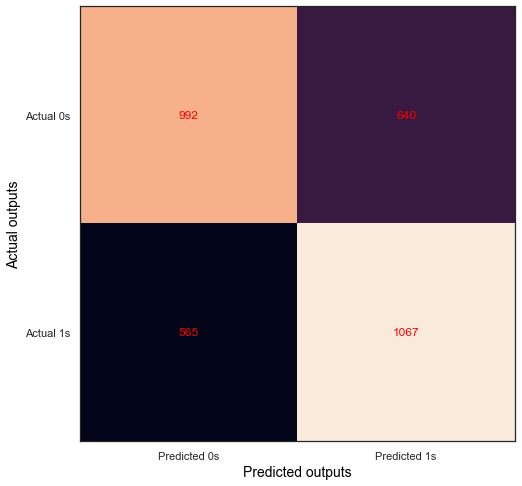

In [506]:
from sklearn.preprocessing import StandardScaler

def logit_regression(df_reg_emotion):
    le_emotion = preprocessing.LabelEncoder()
    df_reg_emotion["flagged"] = le_emotion.fit_transform(df_reg_emotion["flagged"])

    X = df_reg_emotion.drop(columns=["flagged"])
    X = sm.add_constant(X)
    Y = df_reg_emotion["flagged"]

    #scaler = StandardScaler()
    #X = scaler.fit_transform(X)

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 1, shuffle=True, stratify=Y)

    model = sm.Logit(Y_train, X_train)
    result = model.fit()
    
    print("\nTrain Accuracy: " + str(sum((result.predict(X_train) >= 0.5).astype(int) == Y_train)/len(Y_train)))
    print("\nTest Accuracy: " + str(sum((result.predict(X_test) >= 0.5).astype(int) == Y_test)/len(Y_test)))
    print(result.summary())
    print(classification_report(Y_test, (result.predict(X_test) >= 0.5).astype(int)))
    cm = confusion_matrix(Y_test, (result.predict(X_test) >= 0.5).astype(int))

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(cm)
    ax.grid(False)
    ax.set_xlabel('Predicted outputs', fontsize=14, color='black')
    ax.set_ylabel('Actual outputs', fontsize=14, color='black')
    ax.xaxis.set(ticks=(0,1),ticklabels=('Predicted 0s', 'Predicted 1s'))
    ax.yaxis.set(ticks=(0,1),ticklabels=('Actual 0s', 'Actual 1s'))
    ax.set_ylim(1.5, -0.5)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
    plt.show()

logit_regression(df_reg_emotion)

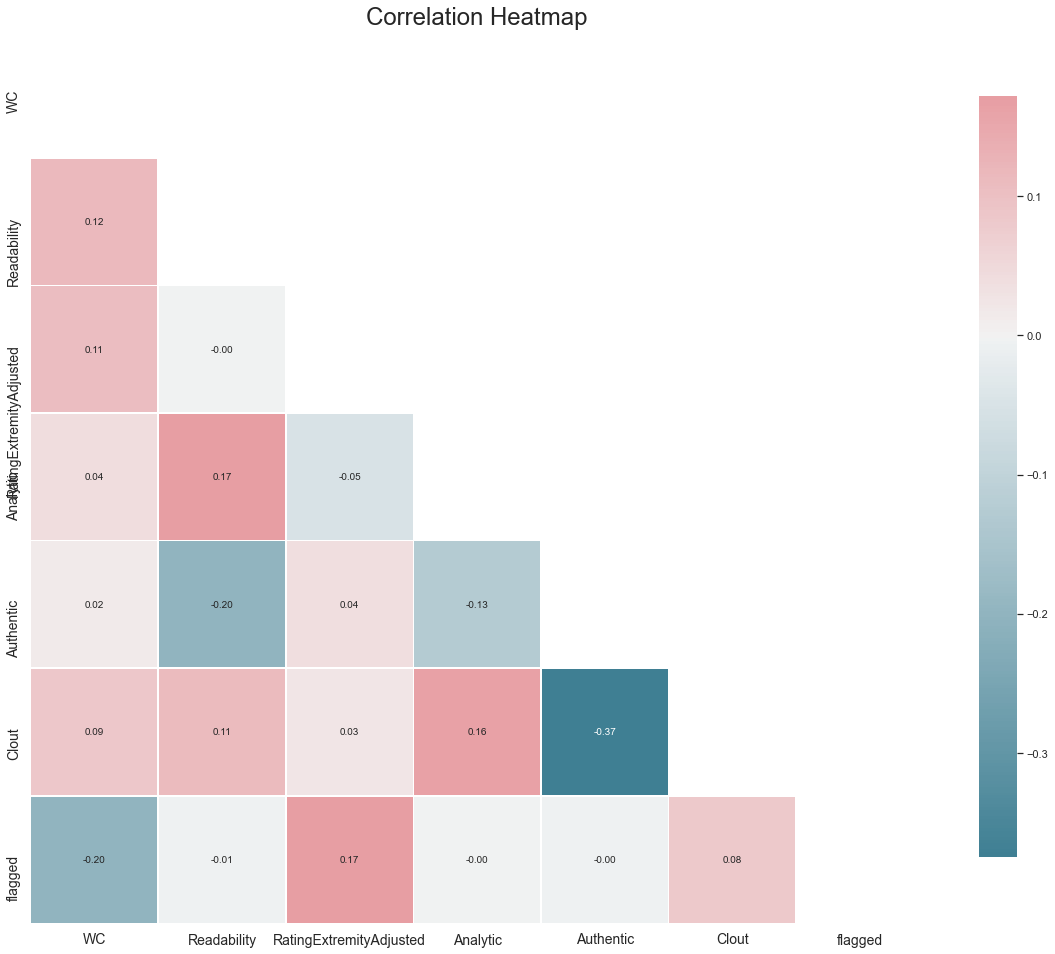

In [407]:
import seaborn as sns
import matplotlib.pyplot as plt

def heatmap(df_fs):
    sns.set(style="white")
    # Calculating Pearson's correlation coefficient of the subsetted data
    correlation = (pd.concat([df_fs.drop(columns=["flagged"]),df_fs["flagged"]], axis=1)).corr()
    mask = np.zeros_like(correlation, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=(20,20))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(correlation, center=0, mask=mask,cmap=cmap,
                fmt='.2f', square=True, linewidths=.5, 
                annot=True, cbar_kws={"shrink": .70},  
                annot_kws={"size": 10})
    ax.set_title('Correlation Heatmap', fontsize = 24)
    ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 14)
    ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 14)

    
heatmap(df_reg_emotion)

## Regression - Emotion + LIWC + Rating

Optimization terminated successfully.
         Current function value: 0.633571
         Iterations 6

Train Accuracy: 0.6449142156862745

Test Accuracy: 0.6409313725490197
                           Logit Regression Results                           
Dep. Variable:                flagged   No. Observations:                13056
Model:                          Logit   Df Residuals:                    13036
Method:                           MLE   Df Model:                           19
Date:                Mon, 25 Jan 2021   Pseudo R-squ.:                 0.08595
Time:                        12:05:26   Log-Likelihood:                -8271.9
converged:                       True   LL-Null:                       -9049.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const      

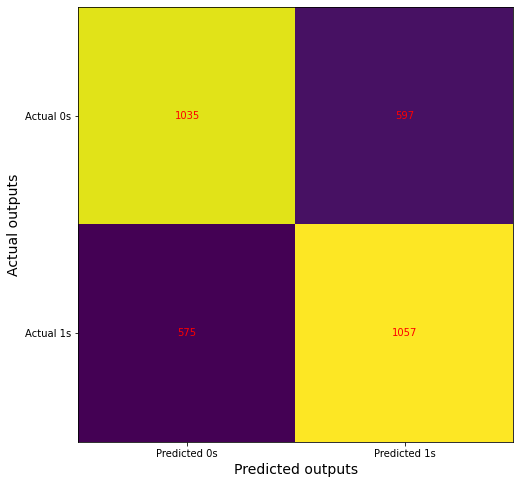

In [337]:
########## Full model #############

df_reg_emotion_full = df_emotion.drop(columns=["RatingPrior","RatingPriorToReview","date","reviewID","reviewerID","review","Rating","restaurantID","Sixltr","Sentences","Letters","pronoun","ppron"])
#df_reg_emotion_full = df_emotion[["anger","joy","disgust","sadness","fear","flagged"]]

logit_regression(df_reg_emotion_full)

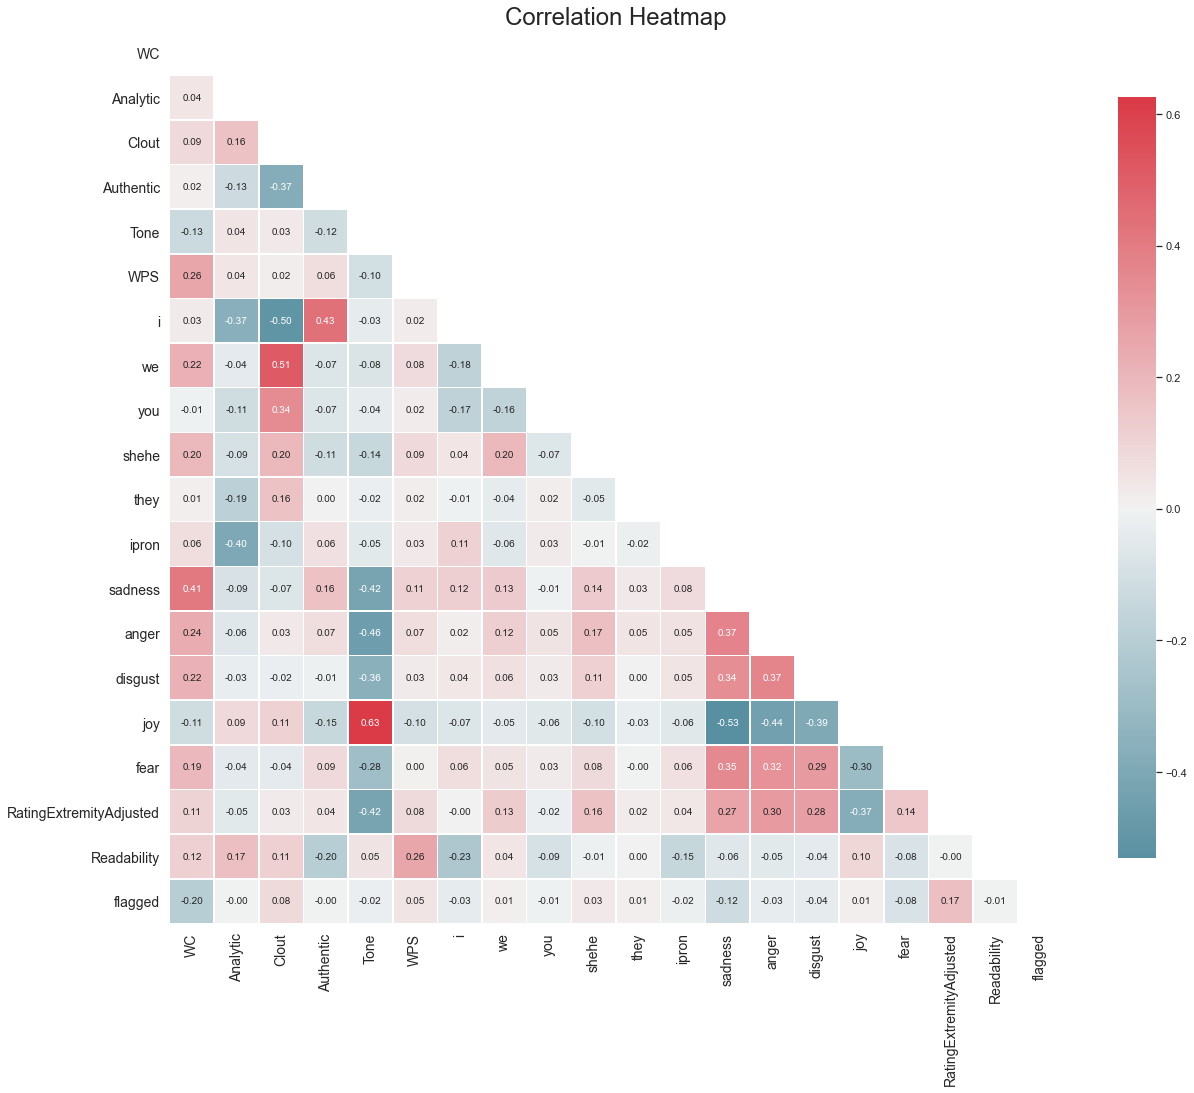

In [408]:
heatmap(df_reg_emotion_full)

## Random Forest

In [629]:
X = df_reg_emotion.drop(columns=["flagged"])
X = sm.add_constant(X)
Y = df_reg_emotion["flagged"]

#scaler = StandardScaler()
#X = scaler.fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 1, shuffle=True, stratify=Y)


In [631]:
from sklearn.metrics import accuracy_score

#from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state = 1, n_estimators=500)
#X = feature_selection(X_train,Y_train, 150)

rf_model.fit(X_train, Y_train)
rf_predictions = rf_model.predict(X_test)
acc = accuracy_score(rf_predictions,Y_test)
acc

0.6262254901960784

/Users/jamesfyfe/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


-- Epoch 1
Norm: 31.47, NNZs: 6, Bias: -5.749392, T: 797, Avg. loss: 11.864247
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 30.76, NNZs: 6, Bias: -3.711975, T: 1594, Avg. loss: 7.801607
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 30.08, NNZs: 6, Bias: 0.052447, T: 2391, Avg. loss: 5.602150
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 30.51, NNZs: 6, Bias: -2.307690, T: 3188, Avg. loss: 4.807268
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 32.43, NNZs: 6, Bias: 2.084102, T: 3985, Avg. loss: 4.093391
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 32.98, NNZs: 5, Bias: 0.119875, T: 4782, Avg. loss: 3.342324
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 35.36, NNZs: 5, Bias: 0.133729, T: 5579, Avg. loss: 3.096459
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 37.13, NNZs: 6, Bias: -1.250050, T: 6376, Avg. loss: 2.855161
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 37.93, NNZs: 5, Bias: 0.117617, T: 7173, Avg. loss: 2.526273
Total training

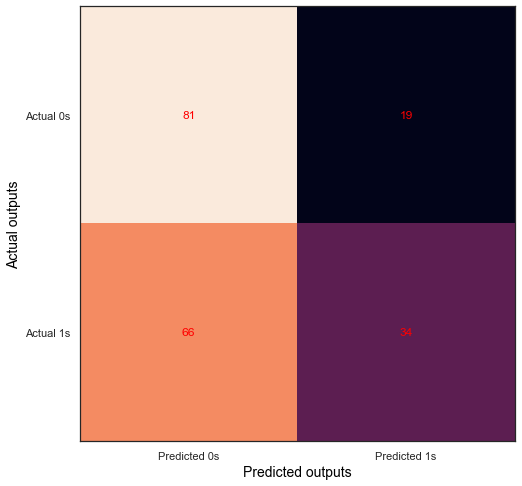

In [744]:
# logistic regression with li+l2 penalty
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDClassifier

      
def logit_regression_en(df_reg_emotion):
    le_emotion = preprocessing.LabelEncoder()
    df_reg_emotion["flagged"] = le_emotion.fit_transform(df_reg_emotion["flagged"])

    X = df_reg_emotion.drop(columns=["flagged"])
  #  X = sm.add_constant(X)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    Y = df_reg_emotion["flagged"]

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 1, shuffle=True, stratify=Y)
   
    clf = SGDClassifier(random_state=1,penalty="elasticnet", verbose=1)
    clf.fit(X_train, Y_train)
    
      
    print("\nTrain Accuracy: " + str(sum((clf.predict(X_train) >= 0.5).astype(int) == Y_train)/len(Y_train)))
    print("\nTest Accuracy: " + str(sum((clf.predict(X_test) >= 0.5).astype(int) == Y_test)/len(Y_test)))
    
    print(classification_report(Y_test, (clf.predict(X_test) >= 0.5).astype(int)))
    cm = confusion_matrix(Y_test, (clf.predict(X_test) >= 0.5).astype(int))

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(cm)
    ax.grid(False)
    ax.set_xlabel('Predicted outputs', fontsize=14, color='black')
    ax.set_ylabel('Actual outputs', fontsize=14, color='black')
    ax.xaxis.set(ticks=(0,1),ticklabels=('Predicted 0s', 'Predicted 1s'))
    ax.yaxis.set(ticks=(0,1),ticklabels=('Actual 0s', 'Actual 1s'))
    ax.set_ylim(1.5, -0.5)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
    plt.show()
    
logit_regression_en(df_reg_emotion)